# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [31]:
import numpy as np
from matplotlib import pyplot as plt
from functools import partial
from scipy.optimize import fmin
import torch
import os, glob

from indentation.indentationset import IndentationSet
from indentation.processing.find_contact import findContact_minimum, findContact_blackMagic, findContact_blackMagic_CNN
from indentation.processing.signal import do_nothing, crop
from indentation.processing.calculate_parameters import parameter_youngs_modulus
from indentation.processing.plotting import plot_curve_parameters_bar, plot_instance_parameters_bar, plot_mean_force_curves
from indentation.ml.models import ConvClassifier_1, ConvClassifier_2

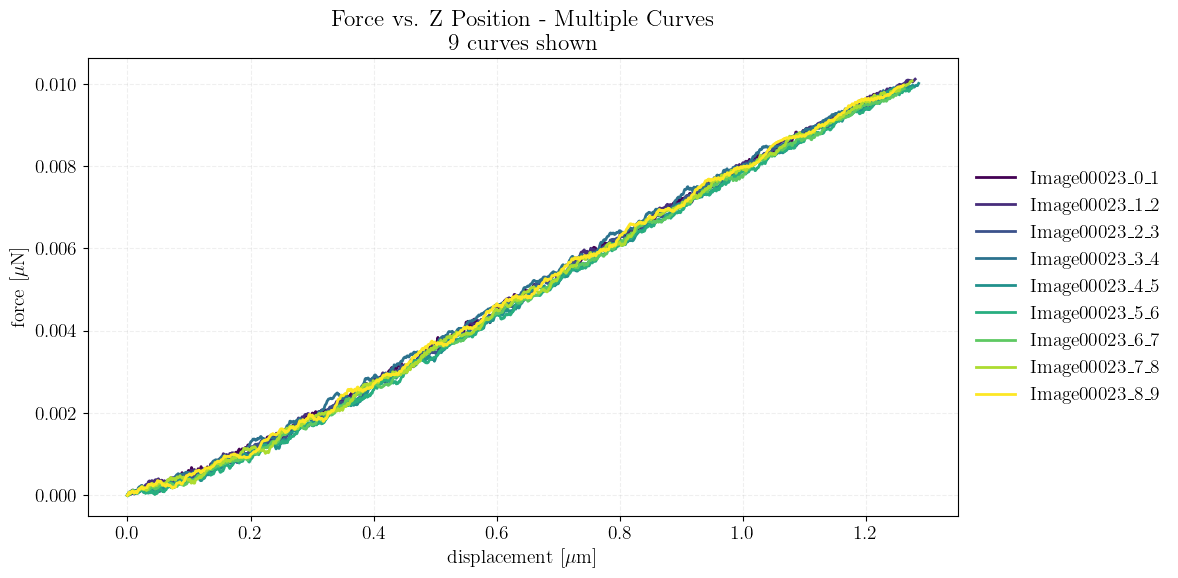

(<Figure size 1200x600 with 1 Axes>,
 <Axes: title={'center': 'Force vs. Z Position - Multiple Curves\n9 curves shown'}, xlabel='displacement [$\\mu$m]', ylabel='force [$\\mu$N]'>)

In [47]:
paths = glob.glob(r"T:\Group\File_Exchange\Raoul_Paula\311024_pdms_30t1_AFM\Image00023_*.txt")

afm = IndentationSet(paths, exp_type="afm")

processing_pl = [crop, findContact_minimum]

afm.process_raw(processing_pl)

afm.plot_all()

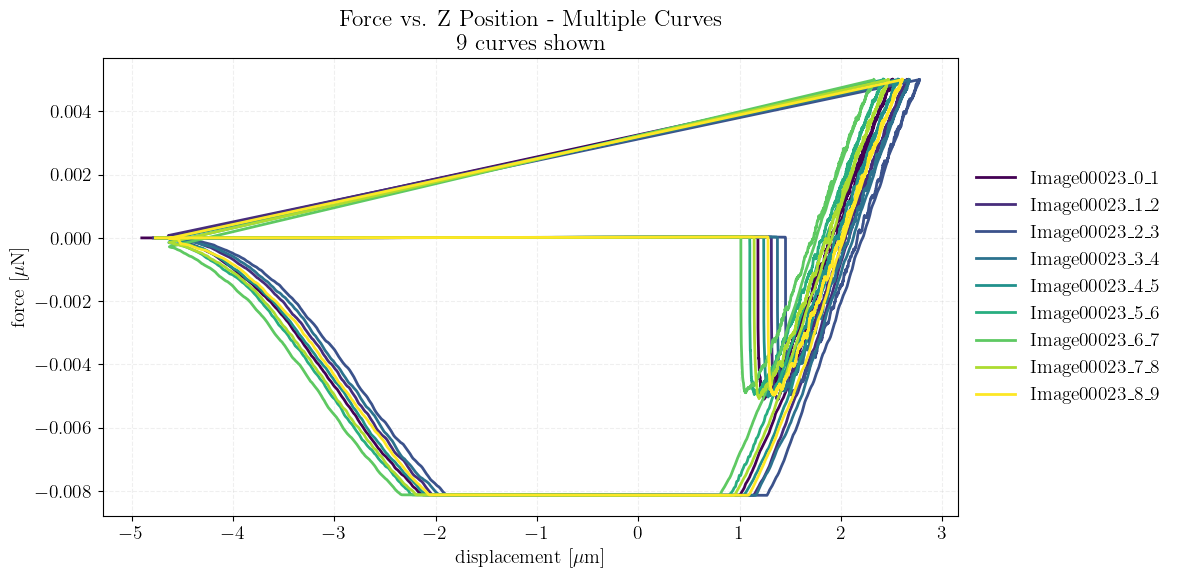

(<Figure size 1200x600 with 1 Axes>,
 <Axes: title={'center': 'Force vs. Z Position - Multiple Curves\n9 curves shown'}, xlabel='displacement [$\\mu$m]', ylabel='force [$\\mu$N]'>)

In [48]:
afm.plot_all_raw()

Mean and std: 2.501111111111111 0.0387138919781874


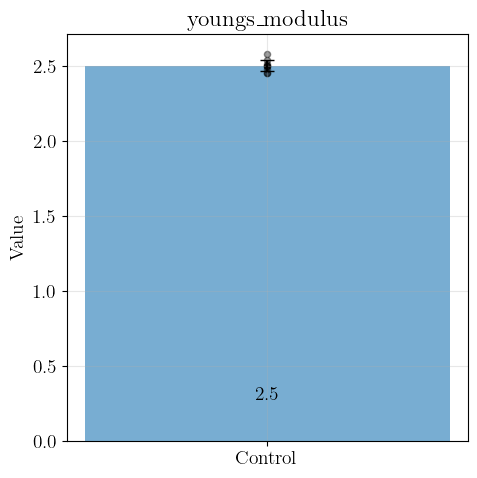

In [46]:
function_arguments = dict(radius=5, nu=0.5, cutoff=10, keyname="youngs_modulus")
afm.calculate_curve_parameter(function=parameter_youngs_modulus, **function_arguments)
plot_curve_parameters_bar(afm,
                         parameter_names=['youngs_modulus'],
                         labels=['Control'],
                         figsize=(5,5))

C:\Users\raulh\indentation\indentation\processing\calculate_parameters.py:107: RuntimeWarning: invalid value encountered in power
  #


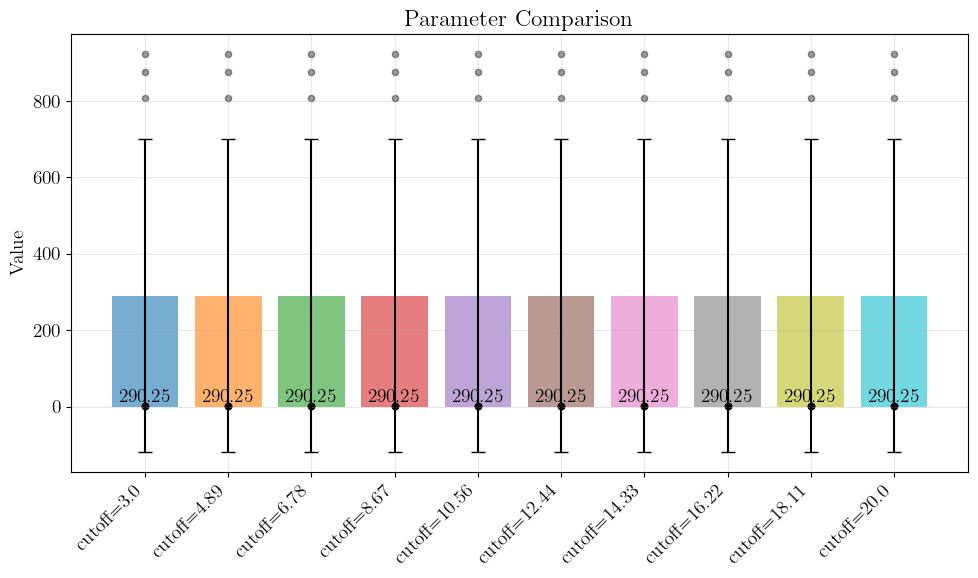

In [21]:
cutoffs = np.linspace(3, 20, 10)

for cutoff in cutoffs:
    function_arguments = dict(radius=5, nu=0.5, cutoff=cutoff, keyname="cutoff="+str(np.round(cutoff, 2)))
    afm.calculate_curve_parameter(function=parameter_youngs_modulus, **function_arguments)

plot_instance_parameters_bar(afm,
                         parameter_names=[*["cutoff="+str(np.round(cutoff, 2)) for cutoff in cutoffs]],
                         figsize=(10,6))

In [28]:
def parse_metadata(file_path):
    metadata = {}
    
    with open(file_path, 'r') as file:
        for line in file:
            # Skip empty lines
            if not line.strip():
                continue
                
            # Stop when we hit a non-metadata line
            if not line.startswith('#'):
                break
                
            key, value = line[1:].strip().split('=')
            
            # Handle different cases based on key
            if key in ['Spring-Constant', 'Deflection-Sensitivity']:
                # Extract number before unit
                value = float(''.join(c for c in value if c.isdigit() or c in '.-e'))
                
            elif key in ['SpecMap-CurIndex', 'SpecMap-PhaseCount']:
                value = int(value)
                
            elif key in ['SpecMap-Dim', 'SpecMap-Size']:
                # Convert semicolon-separated values to numpy array
                value = np.array([float(x) if '.' in x or 'e' in x else int(x) 
                                for x in value.split(';')])
                
            metadata[key] = value
            
    return metadata

In [29]:
parse_metadata(r"T:\Group\File_Exchange\Raoul_Paula\311024_pdms_30t1_AFM\Image00023_0.txt")

{'Filename': 'F:\\pcameron\\3_Experimental\\AFM\\311024\\Image00023.nid',
 'Date': '31-10-2024',
 'Controller': '096-20-046',
 'Scanhead': '75-21-266.hed',
 'Cantilever': 'CP-qp-CONT-BSG-B-5',
 'Spring-Constant': 0.128966,
 'Deflection-Sensitivity': 6.38e-09,
 'SpecMode': 'Map',
 'SpecMap-Dim': array([0.e+00, 2.e-05, 0.e+00, 2.e-05]),
 'SpecMap-Size': array([3, 3, 0, 0]),
 'SpecMap-CurIndex': 0,
 'SpecMap-PhaseCount': 2,
 'Spec-Phase': '0',
 'Spec-Name': 'Spec forward',
 'Spec-Points': '8282',
 'Spec-SampleRate': '0Hz',
 'Spec-Data': 'Z-Axis Sensor [m];Deflection [N];Z-Axis-Out [m]'}

In [39]:
#                zz, vv, _ = np.array(line.split(';'), dtype=float).T
#                zl.append(zz); vl.append(vv)

defl_sens = 6.38e-09
k = 0.12896

z1 = 2.51074e-06
v1 = 6

z_load = 1e6*np.array(z1) # um
v_load = np.array(v1) # V
d_load = defl_sens*v_load # um
f_load = k*d_load # nN
w_load = z_load - d_load

In [41]:
f_load

4.9365887999999994e-09

In [40]:
w_load

2.51073996172